<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/17.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_residencial.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Modelos individuais - reformulação da implementação](16.00.Aula-Modelos_individuais_reformulacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário de múltiplos do Pop350: redes sociais ->](18.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_social.ipynb)

---


# O cenário de múltiplos do Pop350: rede residencial

- O objetivo é criar cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- O **ponto de partida** é a distribuição populacional em blocos do cenário `Pop350`.

- Vamos multiplicar essa população de duas formas:

    - Fazendo **cópias do conjunto de blocos** nas duas direções espaciais.
    
    - **Multiplicando** "uniformemente" **a população de cada bloco**.
    
- No processo, vamos criar algumas **funções úteis para a criação de outros cenários.**

- Neste primeiro caderno, nos ocuparemos de gerar a **rede residencial.**

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy.stats import zipf

import networkx as nx

from numba import jit, njit, prange
from numba.typed import List
import threading # for multi-threading with numba.jit

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 01/Jun/2020


## Multiplicando a distribuição da população do Pop350

- Partimos da região, utilizada anteriormente, com 350 indivíduos divididos em 50 blocos.

- Permitimos cópias desse bloco nas duas direções espaciais.

- E permitimos multiplicação "por escalar" do número de habitantes em cada bloco ("cópias verticais")

### Região original de 350 indivíduos

São $5 x 10 = 50$ blocos, distribuidos em um espaço bidimensional, cada um com uma população dada pela matriz a seguir:

In [5]:
regiao_350_lista = \
    [
        [16, 11, 0, 0,  0,  6,  4,  8,  8,  6],
        [10, 12, 12, 6, 8, 9,  8,  6,  7,  5],
        [0, 10, 14, 10, 12,  8,  0,  0,  6,  8],
        [0, 12, 10, 14, 11,  9,  0,  0,  5,  7],
        [9, 11, 0, 12, 10,  7,  8,  7,  8, 0]
    ]

regiao_350 = np.array(regiao_350_lista)

### Visualização

Podemos visualizar essa população como um *heat map* da matriz:

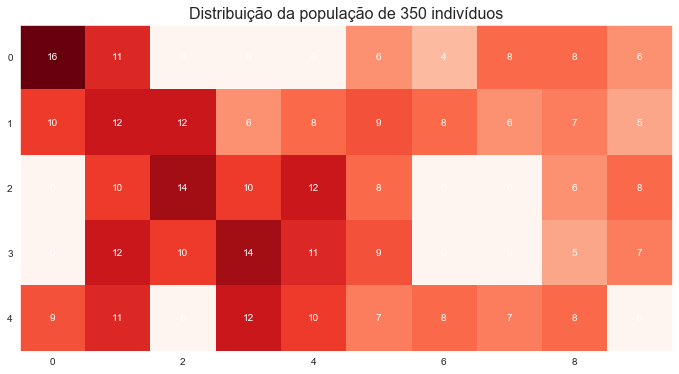

In [6]:
plt.figure(figsize=(12,6))
plt.imshow(regiao_350, cmap='Reds', interpolation='nearest')
N, M = regiao_350.shape
for i in range(N):
    for j in range(M):
        plt.text(j, i, regiao_350[i, j],
                 ha="center", va="center", color="w")
plt.grid(False)
plt.title(f'Distribuição da população de {regiao_350.sum()} indivíduos', fontsize=16)
plt.show()

### Multiplicando a região original

- Unimos cópias dos blocos nas direções espaciais.

- Multiplicamos uniformemente a população de cada bloco.

In [7]:
x_vezes = 3
y_vezes = 2
pop_vezes = 2

aux = []
for l in regiao_350_lista:
    aux.append( x_vezes * l )

regiao_multi_350 = pop_vezes * np.array( y_vezes * aux)

### Total da população

In [8]:
num_pop = regiao_multi_350.sum()
print(num_pop)

4200


### Visualização


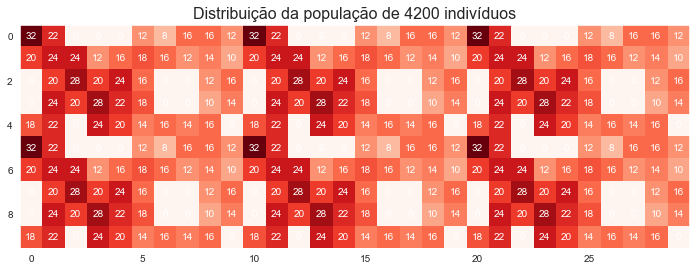

In [9]:
plt.figure(figsize=(12,5))
plt.imshow(regiao_multi_350, cmap='Reds', interpolation='nearest')
N, M = regiao_multi_350.shape
for i in range(N):
    for j in range(M):
        plt.text(j, i, regiao_multi_350[i, j],
                 ha="center", va="center", color="w")
plt.grid(False)
plt.title(f'Distribuição da população de {regiao_multi_350.sum()} indivíduos', fontsize=16)
plt.show()

## Distribuição dos indivíduos por tamanho de residência

- Fazemos, agora, a distribuição dos indivíduos por residência.

### Censo com a distribuição da densidade de população por tamanho da residência

- Em comparação com os dados dos EUA, disponíveis no suplemento do artigo de 2006:

    - reduzi as densidades das residências com poucos indivíduos

    - aumentei as das residências com muitos moradores.

- Não temos dados reais sobre a distribuição completa, mas temos esses dados parciais do censo de **2010** para a *cidade do Rio de Janeiro*:

    - Número de habitantes em 2010: 6.320.446
    
    - Número de residências ocupadas (domicílios) em 2010: 2.147.264
    
    - Média: 2.9435
    
    - Fonte: [IBGE Censo 2010 Rio de Janeiro/RJ](https://cidades.ibge.gov.br/brasil/rj/rio-de-janeiro/pesquisa/23/27652)

### Censo sintético

In [10]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
media = sum([censo_residencial[j]*(j+1) for j in range(len(censo_residencial))])
print(f'Casas de 1 a {len(censo_residencial)} moradores')
print(f'Com densidades de probabilidades {censo_residencial}, respectivamente')
print(f'Total: {sum(censo_residencial)}')
print(f'Média de moradores por residência: {media:.2f}')

Casas de 1 a 8 moradores
Com densidades de probabilidades [0.21 0.26 0.2  0.17 0.08 0.04 0.02 0.02], respectivamente
Total: 1.0
Média de moradores por residência: 2.95


### Visualização

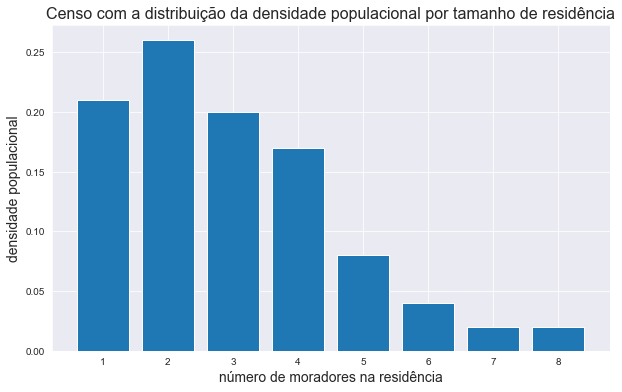

In [11]:
plt.figure(figsize=(10,6))
plt.bar(range(1,len(censo_residencial)+1), censo_residencial)
plt.xlabel('número de moradores na residência', fontsize=14)
plt.ylabel('densidade populacional', fontsize=14)
plt.title('Censo com a distribuição da densidade populacional por tamanho de residência',
          fontsize=16)
plt.show()

## Distribuição em cada bloco das residências por tamanho

- O espaço está dividido em blocos (retângulos), cada um com uma certa população. 

- A ideia é fazer a distribuição da população em cada bloco, separadamente. 

- Em cada bloco, buscamos acompanhar a distribuição geral da densidade populacional por tamanho de residência, descrita pela lista do censo residencial, considerada acima.

### Funções de alocação dos indivíduos

- Utilizamos duas funções:

    - Uma faz uma primeira alocação de acordo com a função densidade de distribuição da população.

    - Por conta de arredondamentos, pode haver uma sobra.

    - A segunda função aloca a sobra de indivíduos, mas sem seguir a distribuição da população.

    - A sobra pode ser alocada de diferentes formas, como veremos a seguir.
    
    - Para populações cada vez maiores, a distribuição se aproxima cada vez mais do censo.

In [12]:
def distribui_residencias_bloco(num_pop_bloco, censo_residencial, modo = 's'):
    '''
    Distribui indivíduos por tamanho de residência, seguindo uma lista com o censo 
    de distribuição dada.
    
    A sobra é distribuida seguinda uma ordem definida pelo argumento `modo`.
    
        Se `modo == 'c'` ("crescente"), a distribuição é do menor 
        para o maior tamanho de residência.

        Se `modo == 'd'` ("decrescente"), a distribuição é do maior 
        para o menor tamanho de residência.
        
        Se `modo == 's'` ("sorteado"), a distribuição é em ordem aleatório.
    '''
    distrib_res_bloco = [int(num_pop_bloco*censo_residencial[k]/(k+1)) 
                                      for k in range(len(censo_residencial))]
    distrib_pop_bloco = [distrib_res_bloco[k]*(k+1) 
                              for k in range(len(censo_residencial))]
    total_bloco = sum(distrib_pop_bloco)
    sobra = num_pop_bloco -  total_bloco
    if sobra > 0:
        distrib_res_bloco, distrib_pop_bloco, sobra \
            = distribui_sobra_bloco(distrib_res_bloco, sobra, modo)
    return distrib_res_bloco, distrib_pop_bloco, sobra

In [13]:
def distribui_sobra_bloco(distrib_res_bloco, sobra, modo = 's'):
    '''
    Distribui a sobra de indivíduos por tamanho de residência.
    
    A sobra é distribuida seguinda uma ordem definida pelo argumento `modo`.
    
        Se `modo == 'c'` ("crescente"), a distribuição é do menor 
        para o maior tamanho de residência.

        Se `modo == 'd'` ("decrescente"), a distribuição é do maior 
        para o menor tamanho de residência.
        
        Se `modo == 's'` ("sorteado"), a distribuição é em ordem aleatório.
    '''
    
    if modo == 'c':
        k_indices = range(1, len(distrib_res_bloco)+1)
    elif modo == 'd':
        k_indices = range(len(distrib_res_bloco), 0, -1)
    else:
        k_aux = list(range(1, len(distrib_res_bloco)+1))
        np.random.shuffle(k_aux)
        k_indices = iter(k_aux)

    for k in k_indices:
        if sobra >= k:
            distrib_res_bloco[k-1] += 1
            sobra -= k
    distrib_pop_bloco = [distrib_res_bloco[k]*(k+1) 
                        for k in range(len(distrib_res_bloco))]
    if sobra > 0:
        distrib_res_bloco, distrib_pop_bloco, sobra \
            = distribui_sobra_bloco(distrib_res_bloco, sobra, modo)
    return distrib_res_bloco, distrib_pop_bloco, sobra

### Testando a função de distribuição residencial dos indivíduos

- A diferença para a distribuição global pode ser grande se a população do bloco for pequena, mas diminui sensivelmente para populações maiores.

- Mas isso será aplicada a cada bloco.

- Se a população de cada bloco for pequena, or erros podem se acumular.

- O modo `sortido` busca remediar isso.

- O modo `sortido` é aleatório, naturalmente, e o seu resultado muda a cada vez que é executado, nem sempre sendo bom. 

- Uma possibilidade é fazer vários sorteios e escolher o mais próximo do censo dado. Mas isso não será necessário nos casos mais realistas, de populações maiores, ou com vários blocos, então não me preocupei em implementar isso, no momento.

In [14]:
print('   0 crescente:   ', distribui_residencias_bloco(0, censo_residencial))
print('   7 sorteado:    ', distribui_residencias_bloco(7, censo_residencial))
print('   7 crescente:   ', distribui_residencias_bloco(7, censo_residencial, 'c'))
print('   7 decrescente: ', distribui_residencias_bloco(7, censo_residencial, 'd'))
print('  18 sorteado:    ', distribui_residencias_bloco(7, censo_residencial))
print('  18 crescente:   ', distribui_residencias_bloco(7, censo_residencial, 'c'))
print('  18 decrescente: ', distribui_residencias_bloco(7, censo_residencial, 'd'))
print('  64 sorteado:    ', distribui_residencias_bloco(7, censo_residencial))
print('  64 crescente:   ', distribui_residencias_bloco(7, censo_residencial, 'c'))
print('  64 decrescente: ', distribui_residencias_bloco(7, censo_residencial, 'd'))
print(' 120 sorteado:    ', distribui_residencias_bloco(7, censo_residencial))
print(' 120 crescente:   ', distribui_residencias_bloco(7, censo_residencial, 'c'))
print(' 120 decrescente: ', distribui_residencias_bloco(7, censo_residencial, 'd'))
print('1000 sorteado:    ', distribui_residencias_bloco(7, censo_residencial))
print('1000 crescente:   ', distribui_residencias_bloco(7, censo_residencial, 'c'))
print('1000 decrescente: ', distribui_residencias_bloco(7, censo_residencial, 'd'))

   0 crescente:    ([0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], 0)
   7 sorteado:     ([2, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 5, 0, 0, 0], 0)
   7 crescente:    ([2, 1, 1, 0, 0, 0, 0, 0], [2, 2, 3, 0, 0, 0, 0, 0], 0)
   7 decrescente:  ([1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 6, 0, 0], 0)
  18 sorteado:     ([2, 0, 0, 0, 1, 0, 0, 0], [2, 0, 0, 0, 5, 0, 0, 0], 0)
  18 crescente:    ([2, 1, 1, 0, 0, 0, 0, 0], [2, 2, 3, 0, 0, 0, 0, 0], 0)
  18 decrescente:  ([1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 6, 0, 0], 0)
  64 sorteado:     ([2, 1, 1, 0, 0, 0, 0, 0], [2, 2, 3, 0, 0, 0, 0, 0], 0)
  64 crescente:    ([2, 1, 1, 0, 0, 0, 0, 0], [2, 2, 3, 0, 0, 0, 0, 0], 0)
  64 decrescente:  ([1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 6, 0, 0], 0)
 120 sorteado:     ([1, 1, 0, 1, 0, 0, 0, 0], [1, 2, 0, 4, 0, 0, 0, 0], 0)
 120 crescente:    ([2, 1, 1, 0, 0, 0, 0, 0], [2, 2, 3, 0, 0, 0, 0, 0], 0)
 120 decrescente:  ([1, 0, 0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 6, 0, 0], 0)
1000 sorteado:     ([2, 1

### Comparando os resultados com o censo

- Criamos uma função de exibição apenas para facilitar a visualização das diversas comparações.

- Em seguida, comparamos a distribuição de diversas populações.

In [15]:
def exibe_densidades_bloco(pop):
    num_tam_res = len(censo_residencial)
    
    distrib_res_bloco_c, distrib_pop_bloco_c, sobra \
        = distribui_residencias_bloco(pop, censo_residencial, 'c')
    distrib_res_bloco_d, distrib_pop_bloco_d, sobra \
        = distribui_residencias_bloco(pop, censo_residencial, 'd')
    distrib_res_bloco_s, distrib_pop_bloco_s, sobra \
        = distribui_residencias_bloco(pop, censo_residencial, 's')
    densidade_pop_bloco_c = [distrib_pop_bloco_c[j]/pop for j in range(num_tam_res)]
    densidade_pop_bloco_d = [distrib_pop_bloco_d[j]/pop for j in range(num_tam_res)]
    densidade_pop_bloco_s = [distrib_pop_bloco_s[j]/pop for j in range(num_tam_res)]

    rms_c = np.sqrt(sum([(densidade_pop_bloco_c[j] - censo_residencial[j])**2 
                         for j in range(num_tam_res)]))
    rms_d = np.sqrt(sum([(densidade_pop_bloco_d[j] - censo_residencial[j])**2 
                         for j in range(num_tam_res)]))
    rms_s = np.sqrt(sum([(densidade_pop_bloco_s[j] - censo_residencial[j])**2 
                         for j in range(num_tam_res)])) 
    
    media_c = sum([densidade_pop_bloco_c[j]*(j+1) for j in range(num_tam_res)])
    media_d = sum([densidade_pop_bloco_d[j]*(j+1) for j in range(num_tam_res)])
    media_s = sum([densidade_pop_bloco_s[j]*(j+1) for j in range(num_tam_res)])
    
    bar_width = 0.18
    r1 = [j for j in range(1,num_tam_res+1)]
    r2 = [j+0.19 for j in range(1,num_tam_res+1)]
    r3 = [j+0.38 for j in range(1,num_tam_res+1)]
    r4 = [j+0.57 for j in range(1,num_tam_res+1)]

    plt.figure(figsize=(12,6))
    plt.bar(r1, censo_residencial, width=bar_width, label='censo')
    plt.bar(r2, densidade_pop_bloco_c, width=bar_width,
            label=f'distrib. crescente (rms = {rms_c:.2f}, média = {media_c:.2f})')
    plt.bar(r3, densidade_pop_bloco_d, width=bar_width,
            label=f'distrib. decrescente (rms = {rms_d:.2f}, média = {media_d:.2f})')
    plt.bar(r4, densidade_pop_bloco_s, width=bar_width,
            label=f'distrib. sortido (rms = {rms_s:.2f}, média = {media_s:.2f})')
    plt.xlabel('número de moradores da residência', fontsize=14)
    plt.ylabel('densidade populacional', fontsize=14)
    plt.legend(fontsize=12)
    plt.title(f'Densidade de distribuição populacional por tamanho de residência para {pop} indivíduos',
              fontsize=16)
    plt.show()    

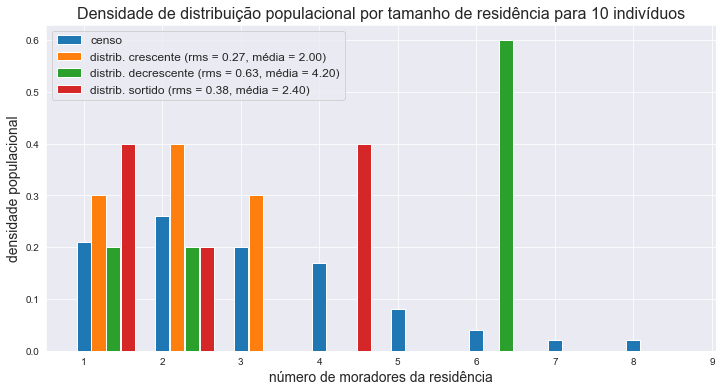

In [16]:
exibe_densidades_bloco(10)

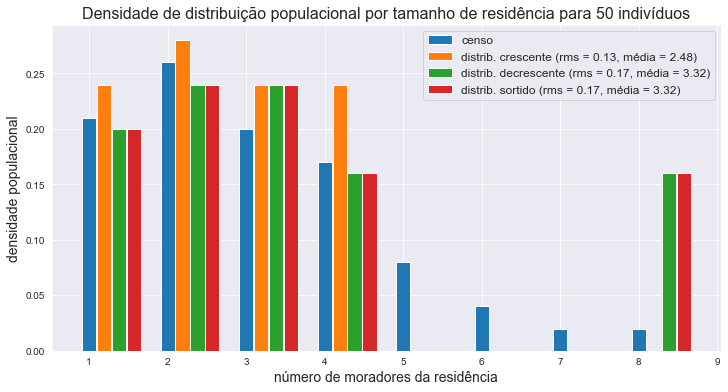

In [17]:
exibe_densidades_bloco(50)

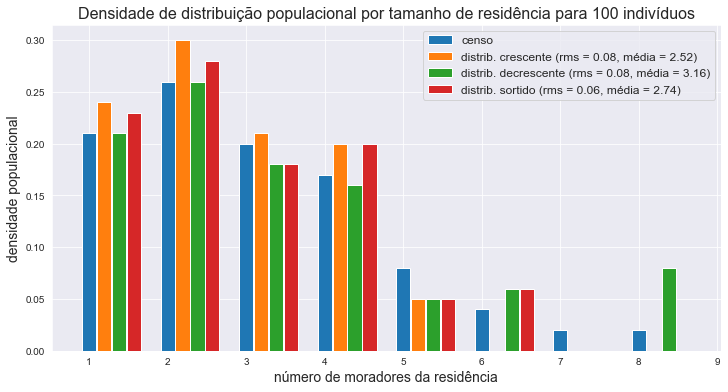

In [18]:
exibe_densidades_bloco(100)

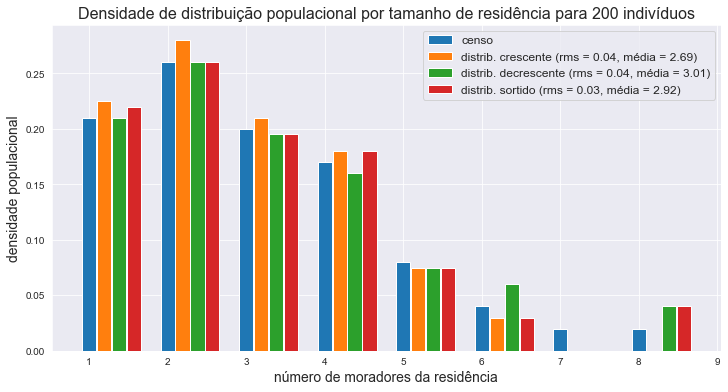

In [19]:
exibe_densidades_bloco(200)

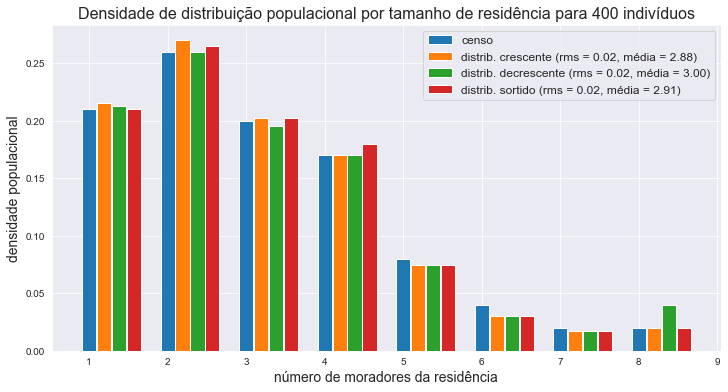

In [20]:
exibe_densidades_bloco(400)

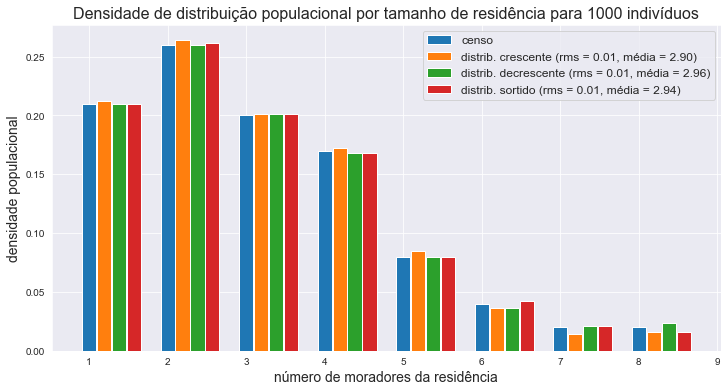

In [21]:
exibe_densidades_bloco(1000)

## Distribuição em toda a região das residências e dos moradores de cada residência

Com base na função de distribuição por bloco, podemos fazer a distribuição em toda a região.

### Função de distribuição dos indivíduos em toda a região

In [22]:
def distribui_residencias_e_individuos(regiao, censo_residencial, modo = 's'):
    N, M = regiao.shape
    distrib_res_regiao = []
    distrib_pop_regiao = []
    for i in range(N):
        aux_res = []
        aux_pop = []
        for j in range(M):
            distrib_res_bloco, distrib_pop_bloco, sobra \
                = distribui_residencias_bloco(regiao[i, j], censo_residencial, modo)
            aux_res.append(distrib_res_bloco)
            aux_pop.append(distrib_pop_bloco)
            assert(sobra == 0), f'Não foi possível alocar toda a população do bloco ({i}, {j})'
        distrib_res_regiao += aux_res
        distrib_pop_regiao += aux_pop
    return distrib_res_regiao, distrib_pop_regiao

### Aplicando a função de distribuição em toda a região 

In [23]:
distrib_res_regiao, distrib_pop_regiao \
    = distribui_residencias_e_individuos(regiao_multi_350, censo_residencial, 's')

### Analisando o resultado

In [24]:
print(f'Total de blocos: {len(distrib_res_regiao)}')
total_residencias = sum([sum(l) for l in distrib_res_regiao])
print(f'Total de residências: {total_residencias}')
total_populacao = sum([sum(l) for l in distrib_pop_regiao])
print(f'Total da população: {total_populacao}')
print(f'Média de moradores por residência: {total_populacao/total_residencias:.2f}')
distribuicao_residencias = [0 for j in range(len(distrib_res_regiao[0]))]
distribuicao_populacao = [0 for j in range(len(distrib_res_regiao[0]))]
for distrib_bloco in distrib_res_regiao:
    for j in range(len(distribuicao_residencias)):
        distribuicao_residencias[j] += distrib_bloco[j] 
        distribuicao_populacao[j] += (j+1)*distrib_bloco[j]
print('Total da distribuição de residências por tamanho:')
print(f'   {distribuicao_residencias}')
print('Total da distribuição da população por tamanho da residência:')
print(f'   {distribuicao_populacao}')
print(f'Total da população por outra contagem: {sum(distribuicao_populacao)}')
print('Distribuição do número de residências por tamanho, dos primeiros blocos:')
for l in range(10):
    print(f'   {distrib_res_regiao[l]}')

Total de blocos: 300
Total de residências: 2073
Total da população: 4200
Média de moradores por residência: 2.03
Total da distribuição de residências por tamanho:
   [992, 565, 261, 114, 58, 49, 17, 17]
Total da distribuição da população por tamanho da residência:
   [992, 1130, 783, 456, 290, 294, 119, 136]
Total da população por outra contagem: 4200
Distribuição do número de residências por tamanho, dos primeiros blocos:
   [9, 5, 3, 1, 0, 0, 0, 0]
   [5, 3, 1, 0, 0, 0, 0, 1]
   [0, 0, 0, 0, 0, 0, 0, 0]
   [0, 0, 0, 0, 0, 0, 0, 0]
   [0, 0, 0, 0, 0, 0, 0, 0]
   [2, 1, 0, 0, 0, 0, 0, 1]
   [1, 1, 0, 0, 1, 0, 0, 0]
   [3, 2, 1, 0, 0, 1, 0, 0]
   [4, 2, 1, 0, 1, 0, 0, 0]
   [3, 1, 0, 0, 0, 0, 1, 0]


### Visualizando a distribuição obtida

- Criamos uma função de exibição das distribuições de densidades.

- Visualizamos o resultado

In [25]:
def exibe_densidades(regiao, censo_residencial):
    distrib_res_regiao_c, distrib_pop_regiao_c \
        = distribui_residencias_e_individuos(regiao_multi_350, censo_residencial, 'c')
    distrib_res_regiao_d, distrib_pop_regiao_d \
        = distribui_residencias_e_individuos(regiao_multi_350, censo_residencial, 'd')
    distrib_res_regiao_s, distrib_pop_regiao_s \
        = distribui_residencias_e_individuos(regiao_multi_350, censo_residencial, 's')
    
    num_tam_res = len(distrib_res_regiao_c[0])
    distribuicao_residencias_c = [0 for j in range(num_tam_res)]
    distribuicao_populacao_c = [0 for j in range(num_tam_res)]
    distribuicao_residencias_d = [0 for j in range(num_tam_res)]
    distribuicao_populacao_d = [0 for j in range(num_tam_res)]
    distribuicao_residencias_s = [0 for j in range(num_tam_res)]
    distribuicao_populacao_s = [0 for j in range(num_tam_res)]

    for distrib_bloco in distrib_res_regiao_c:
        for j in range(num_tam_res):
            distribuicao_residencias_c[j] += distrib_bloco[j] 
            distribuicao_populacao_c[j] += (j+1)*distrib_bloco[j]
    for distrib_bloco in distrib_res_regiao_d:
        for j in range(num_tam_res):
            distribuicao_residencias_d[j] += distrib_bloco[j] 
            distribuicao_populacao_d[j] += (j+1)*distrib_bloco[j]
    for distrib_bloco in distrib_res_regiao_s:
        for j in range(num_tam_res):
            distribuicao_residencias_s[j] += distrib_bloco[j] 
            distribuicao_populacao_s[j] += (j+1)*distrib_bloco[j]
            
    num_pop = regiao.sum()

    densidade_pop_c = [distribuicao_populacao_c[j]/num_pop for j in range(num_tam_res)]
    densidade_pop_d = [distribuicao_populacao_d[j]/num_pop for j in range(num_tam_res)]
    densidade_pop_s = [distribuicao_populacao_s[j]/num_pop for j in range(num_tam_res)]
    
    rms_c = np.sqrt(sum([p**2 for p in densidade_pop_c]))
    rms_d = np.sqrt(sum([p**2 for p in densidade_pop_d]))
    rms_s = np.sqrt(sum([p**2 for p in densidade_pop_s]))
    
    
    rms_c = np.sqrt(sum([(densidade_pop_c[j] - censo_residencial[j])**2 
                         for j in range(num_tam_res)]))
    rms_d = np.sqrt(sum([(densidade_pop_d[j] - censo_residencial[j])**2 
                         for j in range(num_tam_res)]))
    rms_s = np.sqrt(sum([(densidade_pop_s[j] - censo_residencial[j])**2 
                         for j in range(num_tam_res)])) 
    
    media_c = sum([densidade_pop_c[j]*(j+1) for j in range(num_tam_res)])
    media_d = sum([densidade_pop_d[j]*(j+1) for j in range(num_tam_res)])
    media_s = sum([densidade_pop_s[j]*(j+1) for j in range(num_tam_res)])    

    bar_width = 0.18
    r1 = [j for j in range(1,len(censo_residencial)+1)]
    r2 = [j+0.19 for j in range(1,len(densidade_pop_c)+1)]
    r3 = [j+0.38 for j in range(1,len(densidade_pop_d)+1)]
    r4 = [j+0.57 for j in range(1,len(densidade_pop_s)+1)]

    plt.figure(figsize=(12,6))
    plt.bar(r1, censo_residencial, width=bar_width, label=f'censo')
    plt.bar(r2, densidade_pop_c, width=bar_width,
            label=f'distrib. crescente (rms = {rms_c:.2f}, média = {media_c:.2f})')
    plt.bar(r3, densidade_pop_d, width=bar_width,
            label=f'distrib. decrescente (rms = {rms_d:.2f}, média = {media_d:.2f})')
    plt.bar(r4, densidade_pop_s, width=bar_width,
            label=f'distrib. sortido (rms = {rms_s:.2f}, média = {media_s:.2f})')
    plt.xlabel('número de moradores da residência', fontsize=14)
    plt.ylabel('densidade populacional', fontsize=14)
    plt.legend(fontsize=12)
    plt.title('Densidade de distribuição populacional por tamanho de residência para',
              fontsize=16)
    plt.show()    

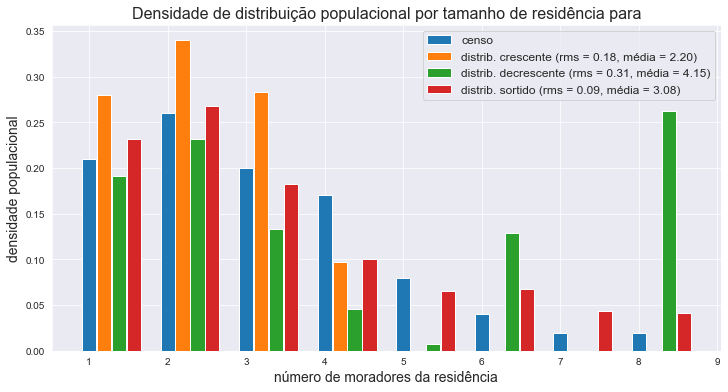

In [26]:
exibe_densidades(regiao_multi_350, censo_residencial)

## Posicionamento dos indivíduos

- Agora, posicionamos os indivíduos de acordo com a população em cada bloco e a distribuição da população por tamanho de residência:

    - A ideia é dividir cada bloco em diversos subblocos, com folga para que cada bloquinho contenha uma única residência.

    - Depois, posicionamos os indivíduos separadamente dentro do sub-bloco da sua residência.

    - Finalmente, agrupamos todos o indivíduos de uma mesma residência em um rede completa.
    
    - Fazemos isso bloco a bloco

### Posicionamente por bloco

Vamos considerar, como exemplo, o bloco localizado nas coordenadas $(1,5)$ da região toda (segunda linha, sexta coluna da matriz `regiao_multi_350`).

#### Dados do bloco

In [27]:
ii = 1
jj = 5
distrib_res_bloco, distrib_pop_bloco, sobra \
        = distribui_residencias_bloco(regiao_multi_350[ii][jj], censo_residencial)
num_residencias_bloco = sum(distrib_res_bloco)
print(f'Bloco: ({ii}, {jj})')
print(f'População: {regiao_multi_350[ii][jj]}')
print(f'Número de residências: {num_residencias_bloco}')
print(f'Distribuição das residências por tamanho: {distrib_res_bloco}')
print(f'Distribuição de moradores por tamanho de residência: {distrib_pop_bloco}')
print(f'Conferindo a população: {sum(distrib_pop_bloco)}')

Bloco: (1, 5)
População: 18
Número de residências: 7
Distribuição das residências por tamanho: [3, 2, 1, 0, 0, 0, 0, 1]
Distribuição de moradores por tamanho de residência: [3, 4, 3, 0, 0, 0, 0, 8]
Conferindo a população: 18


#### Alocação das residências

In [28]:
np.random.seed(2020)
sorteio_lista = list(range(num_residencias_bloco**2))
np.random.shuffle(sorteio_lista) # embaralha "in place"
sorteio = sorteio_lista[:num_residencias_bloco]
print(f'Número de residências: {num_residencias_bloco}')
print(f'Posicionamento alinhado: {sorteio}')
pos_residencias = [( (k // num_residencias_bloco + 1/2) / num_residencias_bloco, 
                     (k % num_residencias_bloco + 1/2) / num_residencias_bloco )
                   for k in sorteio]
print(f'Posicionamento em coordenadas:')
for k in range(len(pos_residencias)):
    print(f'    ({pos_residencias[k][0]:.2f}, {pos_residencias[k][1]:.2f})')

Número de residências: 7
Posicionamento alinhado: [18, 39, 31, 12, 25, 36, 0]
Posicionamento em coordenadas:
    (0.36, 0.64)
    (0.79, 0.64)
    (0.64, 0.50)
    (0.21, 0.79)
    (0.50, 0.64)
    (0.79, 0.21)
    (0.07, 0.07)


#### Visualização da localização das residências

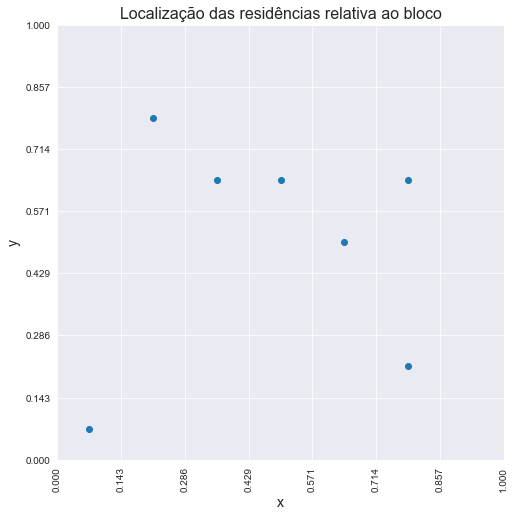

In [29]:
pos_residencias_x = [pos_residencias[i][0] for i in range(len(pos_residencias))]
pos_residencias_y = [pos_residencias[j][1] for j in range(len(pos_residencias))]
plt.figure(figsize=(8,8))
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([i/num_residencias_bloco for i in range(num_residencias_bloco+1)], rotation='vertical')
plt.yticks([j/num_residencias_bloco for j in range(num_residencias_bloco+1)])
plt.plot(pos_residencias_x, pos_residencias_y, 'o')
plt.title('Localização das residências relativa ao bloco', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.show()

#### Alocação dos indivíduos em torno de suas respectivas residências

In [30]:
pos_individuos = [] # posicionamento dos indivíduos
res_individuos = [] # alocação dos indivíduos por residência
m = 0
n = 0
for k in range(len(distrib_res_bloco)):
    for l in range(1, distrib_res_bloco[k]+1):
        res_individuos_l = []
        for i in range(k+1):
            if k == 0:
                x = pos_residencias[m][0]
                y = pos_residencias[m][1]
            else:
                x = pos_residencias[m][0] + np.cos(i*2*np.pi/(k+1))/3/num_residencias_bloco
                y = pos_residencias[m][1] + np.sin(i*2*np.pi/(k+1))/3/num_residencias_bloco
            pos_individuos.append((x,y))
            res_individuos_l.append(n)   
            n += 1
        res_individuos.append(res_individuos_l)
        m += 1
        
for j in range(len(res_individuos)):
    print(f'Indivíduo(s) na residência {j}: {res_individuos[j]}')

Indivíduo(s) na residência 0: [0]
Indivíduo(s) na residência 1: [1]
Indivíduo(s) na residência 2: [2]
Indivíduo(s) na residência 3: [3, 4]
Indivíduo(s) na residência 4: [5, 6]
Indivíduo(s) na residência 5: [7, 8, 9]
Indivíduo(s) na residência 6: [10, 11, 12, 13, 14, 15, 16, 17]


#### Visualização da alocação dos indivíduos

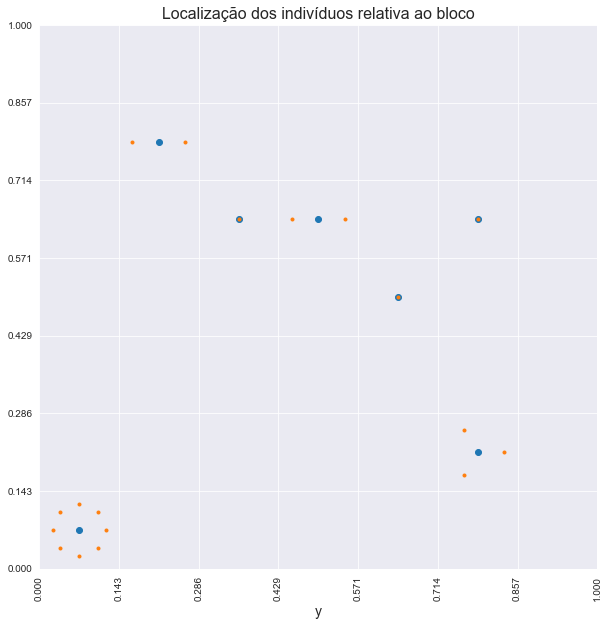

In [31]:
pos_residencias_x = [pos_residencias[j][0] for j in range(len(pos_residencias))]
pos_residencias_y = [pos_residencias[j][1] for j in range(len(pos_residencias))]
x = [pos_individuos[i][0] for i in range(len(pos_individuos))]
y = [pos_individuos[i][1] for i in range(len(pos_individuos))]
plt.figure(figsize=(10,10))
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([j/num_residencias_bloco for j in range(num_residencias_bloco+1)],
           rotation='vertical')
plt.yticks([j/num_residencias_bloco for j in range(num_residencias_bloco+1)])
plt.plot(pos_residencias_x, pos_residencias_y, 'o')
plt.plot(x, y, '.')
plt.title('Localização dos indivíduos relativa ao bloco', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.xlabel('y', fontsize=14)
plt.show()

#### Função de alocação

- Para facilitar, podemos definir funções para executar, repetidamente, esse processo de alocação por bloco:

    - Uma função para alocar as residências.
    
    - Uma função para alocar os indivíduos em suas residências.
    
- Definimos, ainda, uma função para visualização.

In [32]:
def aloca_residencias_bloco(distrib_res):
    '''
    Aloca as residências por tamanho e as posiciona relativamente ao bloco
    '''
    num_residencias = sum(distrib_res)
    sorteio_lista = list(range(num_residencias**2))
    np.random.shuffle(sorteio_lista) # embaralha "in place"
    sorteio = sorteio_lista[:num_residencias]
    pos_residencias = [( k // num_residencias / num_residencias + 1/2/num_residencias, 
                         k % num_residencias / num_residencias + 1/2/num_residencias )
                       for k in sorteio]
    return pos_residencias

In [33]:
def aloca_individuos_bloco(distrib_res, pos_residencias):
    '''
    Aloca e posiciona os indivíduos em residências
    '''
    num_residencias = sum(distrib_res)
    pos_individuos = []
    res_individuos = []
    m = 0
    n = 0
    for k in range(len(distrib_res)):
        for l in range(1, distrib_res[k]+1):
            res_individuos_l = []
            for i in range(k+1):
                if k == 0:
                    x = pos_residencias[m][0]
                    y = pos_residencias[m][1]
                else:
                    x = pos_residencias[m][0] + np.cos(i*2*np.pi/(k+1))/3/num_residencias
                    y = pos_residencias[m][1] + np.sin(i*2*np.pi/(k+1))/3/num_residencias
                pos_individuos.append((x, y))
                res_individuos_l.append(n)
                n += 1
            res_individuos.append(res_individuos_l)
            m += 1
    return pos_individuos, res_individuos

In [34]:
def visualiza_alocacao_bloco(pos_residencias, pos_individuos):
    num_residencias = len(pos_residencias)
    
    pos_residencias_x = [pos_residencias_bloco[j][0] for j in range(len(pos_residencias_bloco))]
    pos_residencias_y = [pos_residencias_bloco[j][1] for j in range(len(pos_residencias_bloco))]
    x = [pos_individuos[i][0] for i in range(len(pos_individuos))]
    y = [pos_individuos[i][1] for i in range(len(pos_individuos))]

    plt.figure(figsize=(10,10))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xticks([j/num_residencias for j in range(num_residencias+1)], rotation='vertical')
    plt.yticks([j/num_residencias for j in range(num_residencias+1)])

    plt.plot(pos_residencias_x, pos_residencias_y, 'o')
    plt.plot(x, y, '.')

    plt.title('Localização dos indivíduos relativa ao bloco', fontsize=16)
    plt.xlabel('x', fontsize=14)
    plt.xlabel('y', fontsize=14)

    plt.show()

#### Testando a função de alocação

Vamos ilustrar com outro bloco.

In [35]:
# bloco (0,0)
np.random.seed(29740)

distrib_res_bloco, distrib_pop_bloco, sobra \
        = distribui_residencias_bloco(regiao_multi_350[0][0], censo_residencial)

pos_residencias_bloco = aloca_residencias_bloco(distrib_res_bloco)

pos_individuos_bloco, res_individuos_bloco \
    = aloca_individuos_bloco(distrib_res_bloco, pos_residencias_bloco)

num_residencias = sum(distrib_res_bloco)

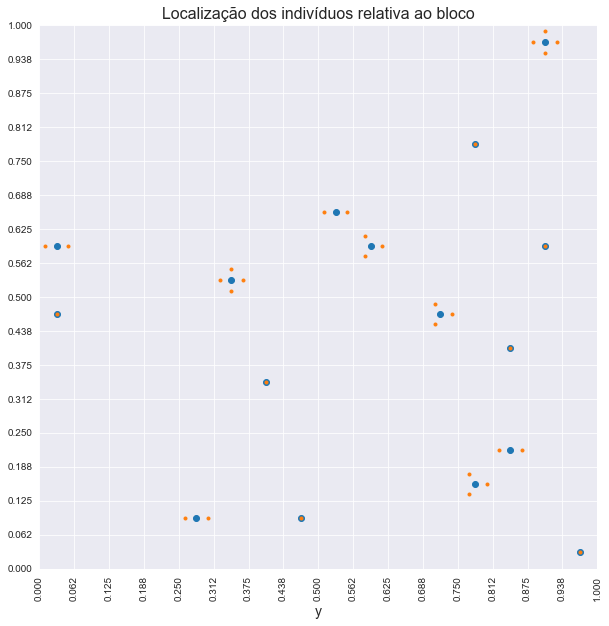

In [36]:
visualiza_alocacao_bloco(pos_residencias_bloco, pos_individuos_bloco)

### Montagem do grafo de conexões residenciais no bloco

In [37]:
attrib_pos_individuos_bloco = {j: pos_individuos_bloco[j] for j in range(len(pos_individuos_bloco))}

G_r = nx.random_geometric_graph(len(attrib_pos_individuos_bloco), 0, pos=attrib_pos_individuos_bloco)

for individuos in res_individuos_bloco:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos])

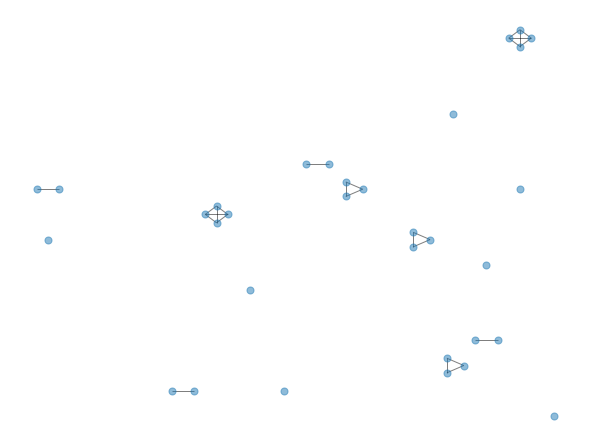

In [38]:
plt.figure(figsize=(8,6))
nx.draw(G_r, pos=attrib_pos_individuos_bloco, node_size=50, alpha=0.5)

### Estendendo o posicionamento para toda a região

Agora, criamos uma função para agregar as funções que agem em cada bloco.

In [39]:
def aloca_residencias_e_individuos(regiao, censo_residencial):
     
    distrib_res_regiao, distrib_pop_regiao \
        = distribui_residencias_e_individuos(regiao, censo_residencial)

    pos_residencias = []
    pos_individuos = []
    res_individuos = []
    n = 0
    N, M = regiao.shape
    for i in range(N):
        for j in range(M):
            pos_residencias_bloco = aloca_residencias_bloco(distrib_res_regiao[i*M + j])

            pos_individuos_bloco, res_individuos_bloco \
                = aloca_individuos_bloco(distrib_res_regiao[i*M + j], pos_residencias_bloco)
            
            pos_residencias_translated \
                = [(j + pos_residencias_bloco[k][1], N - 1 - i + pos_residencias_bloco[k][0])
                   for k in range(len(pos_residencias_bloco))]
            pos_individuos_translated \
                = [(j + pos_individuos_bloco[k][1], N - 1 - i + pos_individuos_bloco[k][0])
                   for k in range(len(pos_individuos_bloco))]
            res_individuos_translated \
                = [[n + l for l in r] for r in res_individuos_bloco]
            
            pos_individuos += pos_individuos_translated
            pos_residencias += pos_residencias_translated
            res_individuos += res_individuos_translated
    
            n += len(pos_individuos_bloco)
    
    return pos_residencias, pos_individuos, res_individuos

In [40]:
def aloca_residencias_e_individuos_test(regiao, censo_residencial):
     
    distrib_res_regiao, distrib_pop_regiao \
        = distribui_residencias_e_individuos(regiao, censo_residencial)

    pos_residencias = []
    pos_individuos = []
    res_individuos = []
    n = 0
    N, M = regiao.shape
    for l in range(M*N):
        pos_residencias_bloco = aloca_residencias_bloco(distrib_res_regiao[l])

        pos_individuos_bloco, res_individuos_bloco \
            = aloca_individuos_bloco(distrib_res_regiao[l], pos_residencias_bloco)

        i = l // M
        j = l % M
        pos_residencias_translated \
            = [(j + pos_residencias_bloco[k][1], N - 1 - i + pos_residencias_bloco[k][0])
               for k in range(len(pos_residencias_bloco))]
        pos_individuos_translated \
            = [(j + pos_individuos_bloco[k][1], N - 1 - i + pos_individuos_bloco[k][0])
               for k in range(len(pos_individuos_bloco))]
        res_individuos_translated \
            = [[n + l for l in r] for r in res_individuos_bloco]

        pos_individuos += pos_individuos_translated
        pos_residencias += pos_residencias_translated
        res_individuos += res_individuos_translated

        n += len(pos_individuos_bloco)
    
    return pos_residencias, pos_individuos, res_individuos

In [41]:
pos_residencias, pos_individuos, res_individuos \
    = aloca_residencias_e_individuos_test(np.array([[regiao_multi_350[1,5]]]), censo_residencial)

#### Aplicando na região original Pop350

In [42]:
pos_residencias, pos_individuos, res_individuos \
    = aloca_residencias_e_individuos(regiao_350, censo_residencial)

In [43]:
%timeit pos_residencias, pos_individuos, res_individuos = aloca_residencias_e_individuos(regiao_multi_350, censo_residencial)
%timeit pos_residencias, pos_individuos, res_individuos = aloca_residencias_e_individuos_test(regiao_multi_350, censo_residencial)

46.4 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
63 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
print(f'Cenário "regiao_350":')
print(f'    número de posições de residências: {len(pos_residencias)}')
print(f'    número de posições de indivíduos: {len(pos_individuos)}')
print(f'    número de residências com lista de residentes: {len(res_individuos)}')

Cenário "regiao_350":
    número de posições de residências: 162
    número de posições de indivíduos: 350
    número de residências com lista de residentes: 162


#### Criando a rede residencial

In [45]:
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(attrib_pos_individuos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos])

#### Visualizando a rede residencial

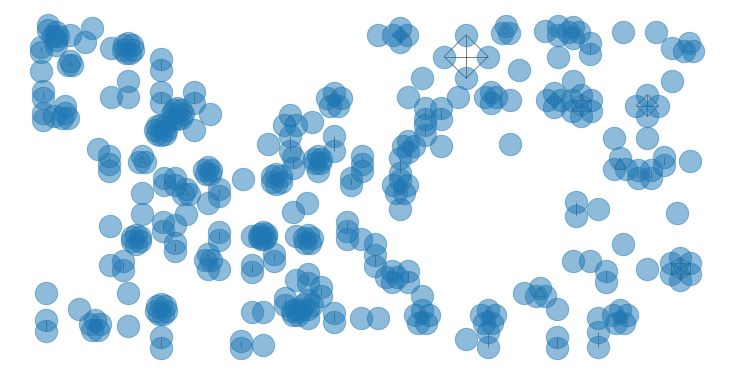

In [46]:
plt.figure(figsize=(10,5))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=500, alpha=0.5)
plt.show()

#### Aplicando na região multi_350

In [47]:
pos_residencias, pos_individuos, res_individuos \
    = aloca_residencias_e_individuos(regiao_multi_350, censo_residencial)

In [48]:
print(f'Cenário "regiao_multi_350":')
print(f'    número de posições de residências: {len(pos_residencias)}')
print(f'    número de posições de indivíduos: {len(pos_individuos)}')
print(f'    número de residências com lista de residentes: {len(res_individuos)}')

Cenário "regiao_multi_350":
    número de posições de residências: 2089
    número de posições de indivíduos: 4200
    número de residências com lista de residentes: 2089


#### Criando a rede residencial

In [49]:
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(attrib_pos_individuos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos])

#### Visualizando a rede residencial

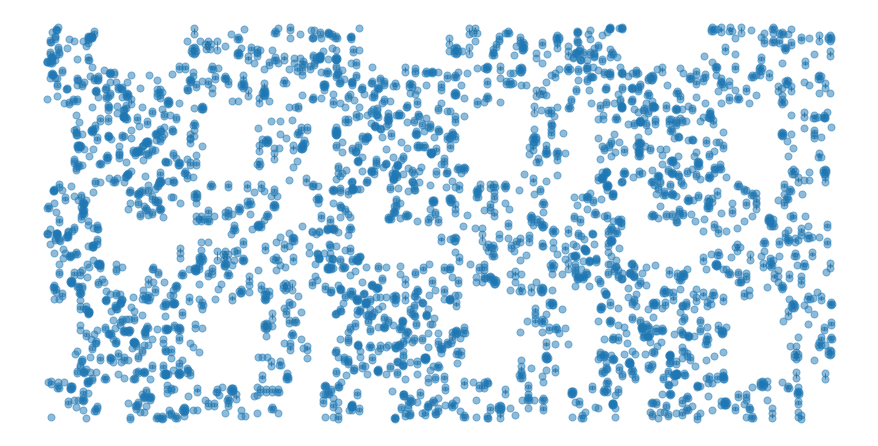

In [50]:
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=50, alpha=0.5)
plt.show()

## Distribuição das idades dos indivíduos

- **Ainda falta implementar**.

- Inicialmente considerei a pirâmide populacional Brasileira.

- Também podemos usar esta pirâmide populacional do cidade do Rio de Janeiro disponível na [Tabela 6407 do IBGE - População residente, por sexo e grupo de idade](https://sidra.ibge.gov.br/tabela/6407#resultado), mas que não diferencia as faixas 60-69, 70-79 e 80 ou mais anos:


| Total | 100,0 |
| --- | --- |
| 0 a 9 anos | 9,4 |
| 10 a 19 anos | 11,9 |
| 20 a 29 anos | 13,2 |
| 30 a 39 anos | 15,5 |
| 40 a 49 anos | 14,2 |
| 50 a 59 anos | 14,0 |
| 60 ou mais | 22,0 |


<!--NAVIGATOR-->

---
[<- Modelos individuais - reformulação da implementação](16.00.Aula-Modelos_individuais_reformulacao.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [O cenário de múltiplos do Pop350: redes sociais ->](18.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_social.ipynb)